# Benchmarking with Circuit

In [1]:
from typing import NamedTuple
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import DOE, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.preferences import kwarg_savefig, outputdir, kwarg_err
from doe_modules.simulation import Circuit, MLR, AbstractSimulator, anova_power, TheoreticalEffects

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: AbstractSimulator = Circuit
    cmap: list = simulator().cmap
    name: str = simulator().name
    run_names: list = None
    n_rep: int = 10
    suffix: str = "_circuit"

conf = Config()

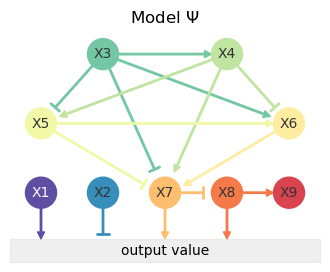

In [3]:
fig, ax = plt.subplots(figsize=(4, 3))

conf.simulator().plot(ax=ax)
ax.set_title(conf.name)

if conf.savefig:
    fig.savefig(f"{conf.out}/sim_model{conf.suffix}", **kwarg_savefig)

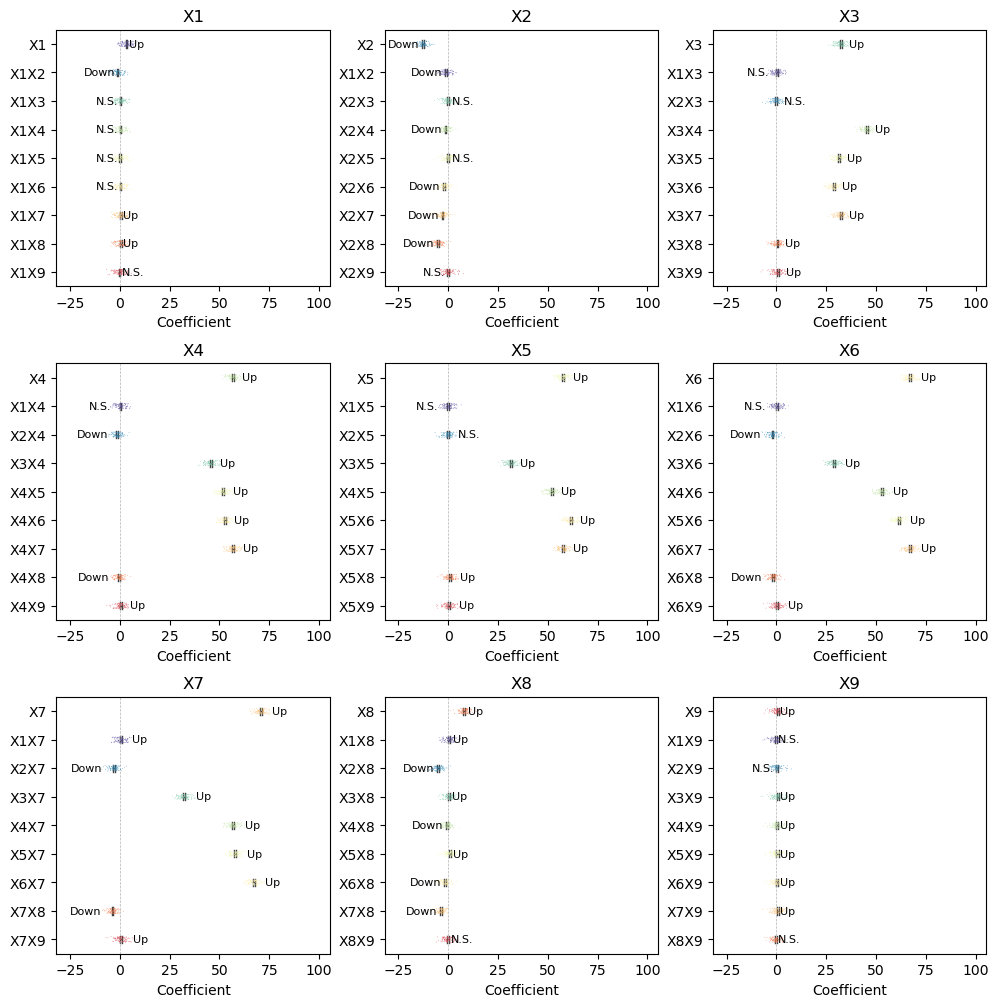

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(hspace=.3)

model = conf.simulator()
gt2 = TheoreticalEffects(simulation=model, interactions=True, order=2)

for i, a in enumerate(ax.ravel()):
    cmap=model.cmap.copy()
    gt2.plot(
        ax=a, cmap=[cmap.pop(i)]+cmap, regex=f"X{i + 1}", 
        jitter_ratio=.06, xscales=np.array([1.6, 1.3]), 
        **kwarg_err
    )
    a.set_title(f"X{i + 1}")

common_xlim = np.abs(
    np.array([a.get_xlim() for a in ax.ravel()])
).max(axis=0) * np.array([-1, 1])

[a.set_xlim(common_xlim) for a in ax.ravel()];

# fig.suptitle(
#     f"{model.metadata['design']}-based second-order model for {model.name} (N={model.metadata['n_rep']})", 
#     y=.93
# );

if conf.savefig:
    fig.savefig(f"{conf.out}/groundtrue_results_2nd_order{conf.suffix}", **kwarg_savefig)

In [5]:
noise_arr = [.5, 1, 2, 4]

noise_conf = [
    dict(kwarg_err=dict(loc=0, scale=sigma)) for sigma in noise_arr
]

noise_names = [
    "$\sigma=" + f"{sigma}$" for sigma in noise_arr
]

n_arr = np.arange(1, 11)

np.random.seed(0)
seeds = np.random.randint(0, 2**32, conf.n_rep)

conditions = dict(
    pb=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr) * seeds.size)),
    cloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr) * seeds.size)),
)

designs = dict(
    pb=PlackettBurman,
    cloo=CLOO,
)

In [6]:
# period: n_noise >> n_rep >> conf.n_rep

for k, models in conditions.items():
    [
        m.simulate(
            design=designs[k],
            n_rep=n_arr[(i // conf.n_rep) % len(n_arr)],
            random_state=seeds[i % conf.n_rep],
            model_kwargs=noise_conf[i // (conf.n_rep * len(n_arr))],
        ) for i, m in enumerate(models)
    ]
    
theoretical = [
    TheoreticalEffects(
        simulation=conf.simulator(), random_state=0, model_kwargs=nc
    ) for nc in noise_conf
]

ground_truth = [
    theoretical[i].summary(dtype=int) for i in np.tile(
        np.arange(len(noise_conf)), 
        len(n_arr) * seeds.size
    ).reshape(-1, len(noise_conf)).T.ravel()
]

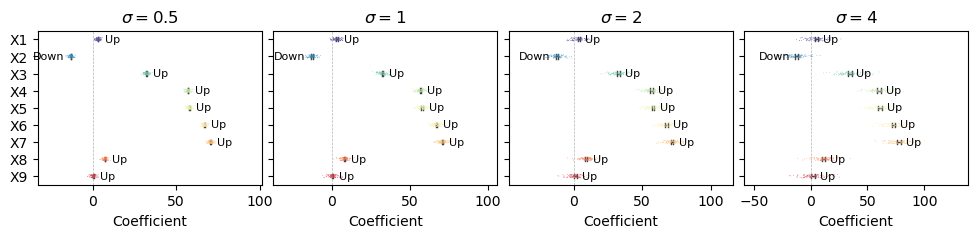

In [7]:
fig, ax = plt.subplots(1, len(noise_arr), figsize=(3 * len(noise_arr), 2), sharey=True)
plt.subplots_adjust(wspace=0.05)

for t, sigma, a in zip(theoretical, noise_conf, ax.ravel()):
    t.plot(ax=a, jitter_ratio=.04, xscales=np.array([1.6, 1.3]), size=.5, **kwarg_err)

    a.set(ylabel="", title="$\sigma=" + f"{sigma['kwarg_err']['scale']}" + "$")

if conf.savefig:
    fig.savefig(f"{conf.out}/groundtrue_results{conf.suffix}", **kwarg_savefig)

In [8]:
warnings.simplefilter('ignore')

pb_metric, cloo_metric = [], []
pb_dd, cloo_dd = [], []
# acc = lambda res, gt: np.nan if res.isna().all() else (1 - (gt - res).abs() / 2).mean()
kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

metric = kappa

for pb, cloo, gt in tqdm(
    zip(conditions["pb"], conditions["cloo"], ground_truth), 
    total=len(ground_truth)
):
    pb_res = MLR(pb).summary(anova=True, dtype=int)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int)
    pb_metric += [metric(pb_res, gt)]
    cloo_metric += [metric(cloo_res, gt)]
    pb_dd += [d_criterion(sm.add_constant(pb.exmatrix))]
    cloo_dd += [d_criterion(sm.add_constant(cloo.exmatrix))]

  0%|          | 0/400 [00:00<?, ?it/s]

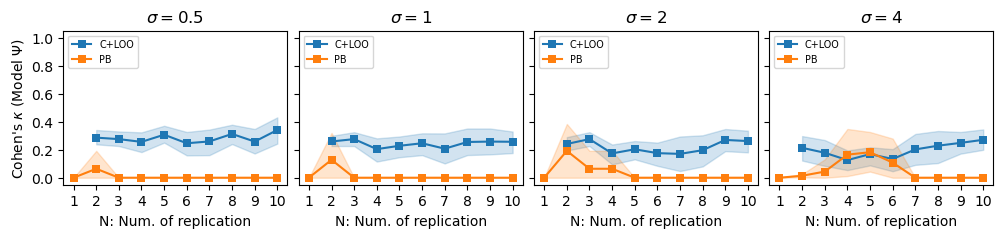

In [9]:
fig, ax = plt.subplots(1, len(noise_arr), figsize=(3 * len(noise_arr), 2), sharey=True)
plt.subplots_adjust(wspace=0.05)

df = pd.DataFrame({
    "n": np.tile(
        np.tile(n_arr, seeds.size).reshape(-1, len(n_arr)).T.ravel(), 
        len(noise_conf)
    ),
    "err": np.ravel([[v] * len(n_arr) * seeds.size for v in noise_arr]),
    "pb_metric": pb_metric,
    "cloo_metric": cloo_metric,
    "pb_dd": pb_dd,
    "cloo_dd": cloo_dd,
})

for i, a in enumerate(ax.ravel()):
    e = df.err.unique()[i]
    sns.lineplot(
        data=df[df.err == e], x="n", y="cloo_metric", marker="s", 
        ax=a, label=conditions["cloo"][0].metadata["design"], 
        markeredgewidth=0, errorbar=("ci", 95), n_boot=1000
    )
    sns.lineplot(
        data=df[df.err == e], x="n", y="pb_metric", marker="s", 
        ax=a, label=conditions["pb"][0].metadata["design"],
        markeredgewidth=0, errorbar=("ci", 95), n_boot=1000
    )
    a.set_ylim(-0.05, 1.05)
    a.set_xticks(n_arr.tolist())
    a.set_yticks(np.linspace(0, 1, 6).tolist())
    a.set(
        title=noise_names[i], xlabel="N: Num. of replication", 
        ylabel=f"Cohen's $\kappa$ ({conf.simulator().name})"
    )
    a.legend(loc="upper left", fontsize="x-small")

# fig.suptitle(f"Weighted accuracy score ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks{conf.suffix}", **kwarg_savefig)

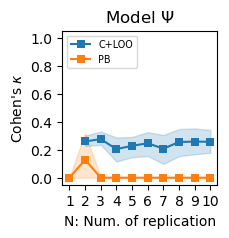

In [10]:
fig, ax = plt.subplots(figsize=(2, 2))


sns.lineplot(
    data=df[df.err == 1], x="n", y="cloo_metric", marker="s", 
    ax=ax, label=conditions["cloo"][0].metadata["design"], 
    markeredgewidth=0, errorbar=("ci", 95), n_boot=1000
)
sns.lineplot(
    data=df[df.err == 1], x="n", y="pb_metric", marker="s", 
    ax=ax, label=conditions["pb"][0].metadata["design"],
    markeredgewidth=0, errorbar=("ci", 95), n_boot=1000
)
ax.set_ylim(-0.05, 1.05)
ax.set(title=conf.simulator().name, xlabel="N: Num. of replication", ylabel=f"Cohen's $\kappa$")
ax.legend(loc="upper left", fontsize="x-small")
ax.set_xticks(n_arr.tolist())
ax.set_yticks(np.linspace(0, 1, 6).tolist())

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks_default{conf.suffix}", **kwarg_savefig)

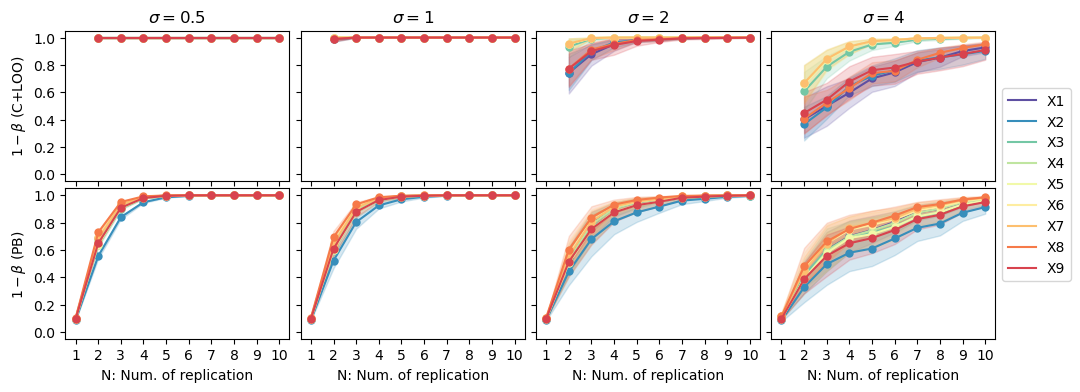

In [11]:
fig, ax = plt.subplots(2, len(noise_arr), figsize=(3 * len(noise_arr), 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

df_pow = pd.concat(
    [
        anova_power(m).assign(
            noise=pd.Series([noise_names[i // (conf.n_rep * n_arr.size)] for _ in m.metadata["factor_list"]])
        ) for i, m in enumerate(conditions["cloo"])
    ] + [
        anova_power(m).assign(
            noise=pd.Series([noise_names[i // (conf.n_rep * n_arr.size)] for _ in m.metadata["factor_list"]])
        ) for i, m in enumerate(conditions["pb"])
    ]
)

for i, a in enumerate(ax.ravel()):
    sns.lineplot(
        data=df_pow[
            (df_pow.noise == noise_names[i % len(noise_arr)]) & (df_pow.model == ["C+LOO", "PB"][i // len(noise_arr)])
        ].reset_index(), 
        x="n_rep", y="power", hue="term",
        ax=a, palette=conf.cmap, marker="o",
        markeredgewidth=0, n_boot=1000
    )
    
    
    a.set_ylim(-0.05, 1.05)
    a.set_xticks(n_arr.tolist())
    a.set_yticks(np.linspace(0, 1, 6).tolist())
    if i % len(noise_arr) == 0:
        a.set_ylabel(r"$1-\beta$" + f" ({['C+LOO', 'PB'][i // len(noise_arr)]})")
        
    a.set_title(noise_names[i % len(noise_arr)]) if i // len(noise_arr) == 0 else a.set_xlabel("N: Num. of replication")

    a.legend(loc="center left", bbox_to_anchor=(1, -.025)) if i == len(noise_arr) - 1 else a.legend().remove()

if conf.savefig:
    fig.savefig(f"{conf.out}/power{conf.suffix}", **kwarg_savefig)

In [12]:
n_add = [int(i) for i in np.arange(2, 7)]

doptims = dict(
    docloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_add) * seeds.size))
)

In [13]:
# period: n_noise >> n_add >> conf.n_rep

n_rep = 3

for i, m in tqdm(enumerate(doptims["docloo"]), total=len(doptims["docloo"])):
    m.simulate(
        design=DOCLOO,
        n_rep=n_rep,
        n_add = n_add[(i // seeds.size) % len(n_add)],
        random_state=seeds[i % seeds.size],
        model_kwargs=noise_conf[i // (seeds.size * len(n_add))],
    )

  0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
do_metric = []

for i, do in tqdm(enumerate(doptims["docloo"]), total=len(doptims["docloo"])):
    do_res = MLR(do).summary(anova=True, dtype=int)
    gt = ground_truth[
        (seeds.size * len(n_arr)) * (i // (seeds.size * len(n_add))) \
        + (n_rep - 1) * seeds.size
    ]
    do_metric += [metric(do_res, gt)]

  0%|          | 0/200 [00:00<?, ?it/s]

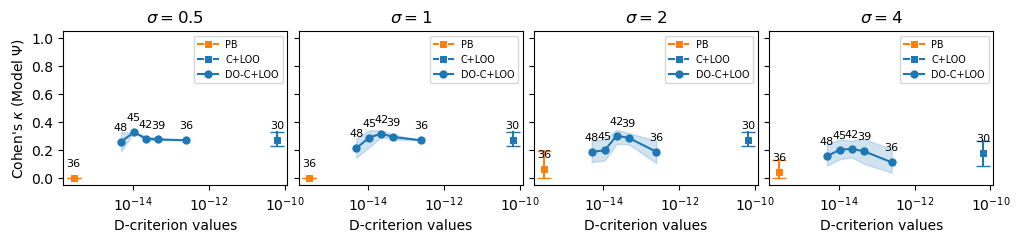

In [17]:
fig, ax = plt.subplots(1, len(noise_arr), figsize=(3 * len(noise_arr), 2), sharey=True)
plt.subplots_adjust(wspace=0.05)

df2 = pd.DataFrame({
    "nmax": [len(m.exmatrix) for m in doptims["docloo"]],
    "d": np.fromiter(
        map(
            d_criterion, 
            map(
                sm.add_constant, 
                [m.exmatrix for m in doptims["docloo"]]
            )
        ), 
        float
    ),
    "err": np.ravel([[v] * len(n_add) * seeds.size for v in noise_arr]),
    "do_metric": do_metric
})

for i, a in enumerate(ax.ravel()):
    e = df2.err.unique()[i]
    
    df_mini = df[(df.err == e) & (df.n == 3)]
    
    plain_idx = (i + 1) * len(n_arr) * seeds.size - 1
    pb, cloo = conditions["pb"][plain_idx], conditions["cloo"][plain_idx]
    sns.lineplot(
        data=df_mini, x="pb_dd", y="pb_metric", 
        ax=a, marker="s", markersize=6, 
        color="C1", err_style="bars", label="PB",
        errorbar=("ci", 95), err_kws={"capsize": 5}, 
        n_boot=1000
    )
    sns.lineplot(
        data=df_mini, x="cloo_dd", y="cloo_metric", 
        ax=a, marker="s", markersize=6, 
        color="C0", err_style="bars", label="C+LOO",
        errorbar=("ci", 95), err_kws={"capsize": 5}, 
        n_boot=1000
    )
    sns.lineplot(
        data=df2[df2.err == e], x="d", y="do_metric", marker="o", 
        ax=a, label="DO-C+LOO", 
        markeredgewidth=0, color="C0", markersize=6,
        errorbar=("ci", 95), n_boot=1000
    )
    a.set_ylim(-0.05, 1.05)
    a.set_yticks(np.linspace(0, 1, 6).tolist())
    a.set(
        title=noise_names[i], xlabel="D-criterion values", 
        ylabel=f"Cohen's $\kappa$ ({conf.simulator().name})"
    )
    a.set_xscale("log")
    a.legend(loc="upper right", fontsize="x-small")
    
    df2_group = df2[df2.err == e].groupby("nmax").mean()
    
    for x, y, t in zip(
        list(df2_group.d) + df_mini.mean()[["pb_dd", "cloo_dd"]].tolist(),
        list(df2_group.do_metric + 0.1) + (df_mini.mean()[["pb_metric", "cloo_metric"]] + 0.1).tolist(),
        list(df2_group.index) 
        + [
            len(conditions["pb"][df_mini.index[-1]].exmatrix), 
            len(conditions["cloo"][df_mini.index[-1]].exmatrix)
        ],
    ):
        a.text(x, y, t, ha="center", va="center", size=8)

# fig.suptitle(f"Weighted accuracy score ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks_with_do{conf.suffix}", **kwarg_savefig)

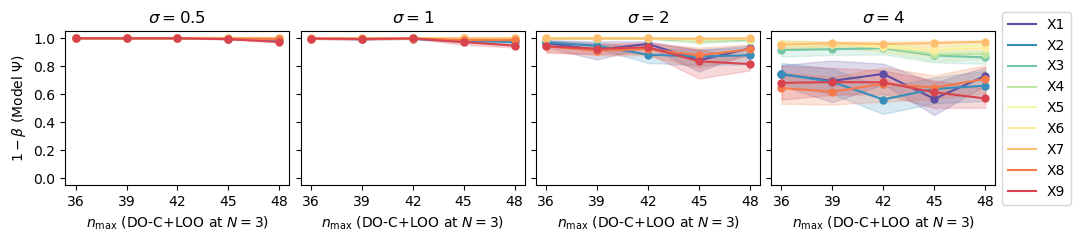

In [16]:
fig, ax = plt.subplots(1, len(noise_arr), figsize=(3 * len(noise_arr), 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

df_pow2 = pd.concat([
    pd.concat([
        anova_power(m),
        pd.DataFrame({
            "d": [d_criterion(sm.add_constant(m.exmatrix)) for _ in m.metadata["factor_list"]],
            "n_max": [len(m.exmatrix) for _ in m.metadata["factor_list"]],
            "noise": [noise_names[i // (conf.n_rep * len(n_add))] for _ in m.metadata["factor_list"]],
        })
    ], axis=1) for i, m in enumerate(doptims["docloo"])
])

for i, a in enumerate(ax.ravel()):
    sns.lineplot(
        data=df_pow2[(df_pow2.noise == noise_names[i % len(noise_arr)])].reset_index(), 
        x="n_max", y="power", hue="term",
        ax=a, palette=conf.cmap, marker="o",
        markeredgewidth=0, n_boot=1000
    )
    
    a.set_xticks(df_pow2.n_max.unique().tolist())
    a.set_ylim(-0.05, 1.05)
    a.set_yticks(np.linspace(0, 1, 6).tolist())
    if i == 0:
        a.set_ylabel(r"$1-\beta$" + f" ({conf.name})")
        
    a.set_title(noise_names[i])
    a.set_xlabel("$n_{\max}$" + f" (DO-C+LOO at $N=" + f"{n_rep})$")

    a.legend(loc="center left", bbox_to_anchor=(1, .5)) if i == len(noise_arr) - 1 else a.legend().remove()

if conf.savefig:
    fig.savefig(f"{conf.out}/power_doptim{conf.suffix}", **kwarg_savefig)